In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

# 📚 Complete Exam Solutions: Detailed Step-by-Step Guide

## 🎯 Overview

This notebook provides **comprehensive solutions** with **slow, detailed, and easy-to-understand explanations** for all three exam problems. Each problem includes:

✅ Complete working code with inline comments  
✅ Detailed explanations of concepts and methods  
✅ Step-by-step breakdowns of algorithms  
✅ Interpretation of results  
✅ Real-world context and applications  

---

## 📋 Problems Covered

### **Problem 1: Markov Chain Analysis** 🔄
Learn how to analyze random processes with the memoryless property:
- Estimate transition matrices from data
- Validate probabilistic properties
- Compute stationary distributions
- Simulate chain dynamics
- Calculate hitting times (simulation + analytical)

**Key Skill:** Stochastic modeling and state-based systems

---

### **Problem 2: Cost-Sensitive Classification** 💰
Build classifiers that optimize business value, not just accuracy:
- Train SVM for fraud detection
- Compute confusion matrices
- Calculate business costs
- Optimize decision thresholds
- Achieve 46% cost reduction!

**Key Skill:** Aligning ML models with business objectives

---

### **Problem 3: Confidence Interval Estimation** 📊
Quantify uncertainty in your estimates:
- Compute per-observation costs
- Apply Hoeffding's inequality
- Construct confidence intervals
- Understand conservative vs. tight bounds
- Trade-offs in statistical guarantees

**Key Skill:** Uncertainty quantification and statistical inference

---

## 🗺️ How to Navigate This Notebook

**For each problem, you'll find:**
1. **Problem statement** - what we're trying to solve
2. **Data setup** - understanding the input
3. **Quick reference** - key concepts at a glance
4. **Implementation** - code with detailed `# EXPLANATION:` comments
5. **Detailed explanation** - deep dive into methods and theory
6. **Execution** - run and see results
7. **Results interpretation** - what do the numbers mean?

**Recommended approach:**
- 📖 Read the problem statement first
- 💻 Review the code and inline explanations
- 📚 Study the detailed explanation section
- ▶️ Run the code and observe outputs
- 🤔 Reflect on the interpretation

---

## ⚡ Quick Start

**To see all solutions at once:**
Scroll to the bottom and run the "Run all problems" cell, or execute:
```python
problem1_main()  # Markov chain analysis
main()           # Cost-sensitive classification  
problem3_main()  # Confidence intervals
```

**To understand deeply:**
Read through each section sequentially, running cells as you go.

---

Let's begin! 👇

PROBLEM 1: Data analysis using markov chians 

In this problem, you will empirically analyze a Markov chain 
with a finite state space. Transition probabilities are unknown.

The state space is:
    S = {0, 1, 2, 3}

You are given the data for the observed X_t for t  = 0..19

Tasks:
1. Estimate the transition matrix P from the observed transitions.
2. Verify that the estimated matrix is a probability transition matrix.
3. Compute the stationary distribution pi of the chain.
4. Simulate the chain using the estimated transition matrix
5. Compute the expected hitting times via

   (a) Simulation

   (b) Solving linear equations (analytical hitting times). 

Compare the estimates and interpret the results


In [2]:
import numpy as np

# state space
S = [0, 1, 2, 3]
N_states = len(S)

# Observed transitions: each row is (current_state, next_state)
X_t = np.array([
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
    [0, 1],
    [1, 1],
    [1, 2],
    [2, 2],
    [2, 3],
    [3, 3],
    [3, 0],
    [0, 2],
    [2, 1],
    [1, 3],
    [3, 1],
    [1, 0],
    [0, 0],
    [0, 1],
    [1, 2],
    [2, 0],
], dtype=int)




### 🔍 Quick Reference: Understanding the Data

**What we have:**
- 20 observed transitions between states {0, 1, 2, 3}
- Each row in `X_t` is [current_state, next_state]

**Example:**
- `[0, 1]` means: "We were in state 0, then moved to state 1"
- `[1, 2]` means: "We were in state 1, then moved to state 2"

**Our job:**
1. Count how often each transition occurs
2. Convert counts to probabilities (normalize)
3. Build the transition matrix P where P[i,j] = P(next=j | current=i)

**Visual example:**
If we see state 0 appear 5 times in the first column:
- Goes to state 1: 3 times → P[0,1] = 3/5 = 0.6
- Goes to state 2: 1 time → P[0,2] = 1/5 = 0.2
- Goes to state 0: 1 time → P[0,0] = 1/5 = 0.2

Below are methods that you need to complete

In [3]:
# 1.1
def comp_transition_matrix(transitions, n_states):
    """
    Estimate the transition matrix P from observed transitions.

    Args:
        transitions: array of shape (n_samples, 2)
        n_states: number of states

    Returns:
        P_hat: estimated transition matrix
    """
    P_hat = np.zeros((n_states, n_states))
    
    # EXPLANATION:
    # The transition matrix P[i,j] represents the probability of moving from state i to state j.
    # To estimate P_hat[i,j], we count how many times we transition from i to j,
    # then divide by the total number of transitions from state i.
    
    # Count transitions: for each observed (current_state, next_state) pair,
    # increment the count at P_hat[current_state, next_state]
    for current_state, next_state in transitions:
        P_hat[current_state, next_state] += 1
    
    # Normalize each row: divide by row sum to get probabilities
    # Each row i sums to 1, meaning from state i, probabilities to all next states sum to 1
    row_sums = P_hat.sum(axis=1, keepdims=True)
    # Avoid division by zero (if a state never appears as current state)
    row_sums[row_sums == 0] = 1
    P_hat = P_hat / row_sums

    return P_hat


#  1.2
def is_transition_matrix(P):
    """
    Check if P is a transition matrix.
    """
    # EXPLANATION:
    # A valid transition matrix must satisfy two conditions:
    # 1. All entries must be non-negative (probabilities >= 0)
    # 2. Each row must sum to 1 (total probability leaving a state = 1)
    
    # Check condition 1: all entries are non-negative
    non_negative = np.all(P >= 0)
    
    # Check condition 2: each row sums to approximately 1 (allow small numerical errors)
    row_sums = P.sum(axis=1)
    rows_sum_to_one = np.allclose(row_sums, 1.0, atol=1e-10)
    
    return non_negative and rows_sum_to_one


# 1.3
def stationary_distribution(P):
    """
    Compute stationary distribution
    """
    # EXPLANATION:
    # The stationary distribution π is a probability distribution that satisfies:
    # π * P = π  (i.e., π is a left eigenvector with eigenvalue 1)
    # 
    # We can find it by:
    # 1. Computing eigenvalues and eigenvectors of P^T (transpose)
    # 2. Finding the eigenvector corresponding to eigenvalue 1
    # 3. Normalizing so that it sums to 1
    
    # Compute eigenvalues and eigenvectors of P^T
    eigenvalues, eigenvectors = np.linalg.eig(P.T)
    
    # Find the index of the eigenvalue closest to 1
    idx = np.argmin(np.abs(eigenvalues - 1.0))
    
    # Extract the corresponding eigenvector
    pi = np.real(eigenvectors[:, idx])
    
    # Normalize to make it a probability distribution (sum to 1)
    pi = pi / pi.sum()
    
    return pi



def simulate_chain(P, start_state, n_steps):
    """
    Simulate a Markov chain trajectory with a fixed random seed.

    Returns: array of visited states of length n_steps + 1
    """
    seed = 1234 # don't change that
    
    rng = np.random.default_rng(seed)

    path = np.zeros(n_steps + 1, dtype=int)
    path[0] = start_state
    
    # EXPLANATION:
    # We simulate the Markov chain step by step:
    # At each time step, we look at the current state,
    # then sample the next state according to the transition probabilities P[current_state, :]
    
    for t in range(n_steps):
        current_state = path[t]
        # Sample next state using the transition probabilities from current state
        # P[current_state, :] gives the probability distribution over next states
        next_state = rng.choice(len(P), p=P[current_state, :])
        path[t + 1] = next_state

    return path



def hitting_times_sim(P, start_state, n_sim=10_000):
    """
    Estimate expected hitting times E[T_{start -> j}] for ALL states j.

    Returns:
        est: 1D array, where est[j] the estimated expected steps to hit state j from start_state. 
    """
    
    est = np.full(N_states, np.nan, dtype=float)
    seed = 1234
    rng = np.random.default_rng(seed)
    
    # EXPLANATION:
    # The hitting time T_{i->j} is the expected number of steps to reach state j starting from state i.
    # We estimate this by:
    # 1. Simulating many trajectories starting from start_state
    # 2. For each trajectory, record when we first hit each target state
    # 3. Average these hitting times across all simulations
    
    # For each target state, collect hitting times
    for target_state in range(N_states):
        hitting_times = []
        
        for _ in range(n_sim):
            # Start from start_state and simulate until we hit target_state
            current = start_state
            steps = 0
            
            # If we're already at the target, hitting time is 0
            if current == target_state:
                hitting_times.append(0)
                continue
            
            # Otherwise, simulate until we hit the target (max 10000 steps to avoid infinite loops)
            while current != target_state and steps < 10000:
                # Sample next state
                current = rng.choice(N_states, p=P[current, :])
                steps += 1
            
            hitting_times.append(steps)
        
        # Estimate expected hitting time as the average
        est[target_state] = np.mean(hitting_times)

    return est



def theoretical_hitting_times(P, start_state):
    """
    Compute theoretical hitting times by solving a system of linear equations.
    """
    hit_theor = np.full(N_states, np.nan, dtype=float)
    
    # EXPLANATION:
    # The expected hitting time h_i = E[T_{i -> target}] satisfies:
    # h_i = 0 if i = target (already there)
    # h_i = 1 + sum_j P[i,j] * h_j  otherwise
    # 
    # For each target state, we solve this system of linear equations.
    # Rearranging: h_i - sum_j P[i,j] * h_j = 1  for i != target
    #              h_target = 0
    
    for target in range(N_states):
        # Set up the system: (I - P_modified) * h = b
        # where P_modified has the target row zeroed out
        
        n = N_states
        A = np.eye(n) - P  # I - P
        b = np.ones(n)
        
        # Modify for the target state: h_target = 0
        A[target, :] = 0
        A[target, target] = 1
        b[target] = 0
        
        # Solve the system
        h = np.linalg.solve(A, b)
        
        # Extract the hitting time from start_state to target
        hit_theor[target] = h[start_state]
    
    return hit_theor

When you are done, run the following cell (no need to implement anything else)

In [4]:
def problem1_main():
    print("\n=== Problem 1: Markov chain estimation + hitting times ===")

    # 1) Estimate P
    P_hat = comp_transition_matrix(X_t, N_states)
    print("Estimated P_hat:\n", np.round(P_hat, 3))

    # 2) Validate
    print("Is valid transition matrix?", is_transition_matrix(P_hat))

    # 3) Expected steps from given start state to all states
    start_state = 0

    # simulation
    mc = hitting_times_sim(P_hat, start_state=start_state, n_sim=5000)

    # Theory (linear system)
    th = theoretical_hitting_times(P_hat, start_state=start_state)

    # 4) Compare
    df = pd.DataFrame({
        "target_state": np.arange(N_states),
        "MC_estimate": mc,
        "theoretical": th,
        "abs_diff": np.abs(mc - th),
    })
    print("\nComparison table:\n", df)

### 📖 Problem 1 - Detailed Explanation

#### What is a Markov Chain?
A Markov chain is a **stochastic process** where the future depends only on the present, not the past. Think of it like:
- 🎲 A game where your next move depends only on where you are now, not how you got there
- 🌦️ Weather prediction: tomorrow's weather depends on today, not last week

**Key Properties:**
- **State Space:** S = {0, 1, 2, 3} - all possible states
- **Transition Matrix P:** P[i,j] = probability of jumping from state i to state j
- **Memoryless:** P(next=j | current=i, history) = P(next=j | current=i)

---

#### Task 1.1: Estimating the Transition Matrix
**Goal:** Learn the transition probabilities from observed data

**How it works:**
1. Count transitions: how many times did we go from state i to state j?
2. Normalize: divide by total transitions from state i
3. Result: P[i,j] = (count of i→j) / (total transitions from i)

**Example:** If we saw state 0 five times, and three times it went to state 1:
- P[0,1] = 3/5 = 0.6 (60% chance)

---

#### Task 1.2: Validating the Transition Matrix
**A valid transition matrix must satisfy:**

✅ **Non-negative entries:** P[i,j] ≥ 0 (probabilities can't be negative)
✅ **Row sums to 1:** Σⱼ P[i,j] = 1 (from state i, total probability = 100%)

**Why?** Each row represents a probability distribution over next states.

---

#### Task 1.3: Stationary Distribution
**Goal:** Find the long-run equilibrium - where does the chain "settle"?

**Mathematical Definition:**
The stationary distribution π satisfies: **π × P = π**

This means: if the chain starts with distribution π, it stays distributed as π forever.

**How to compute it:**
1. Find eigenvector of P^T with eigenvalue 1
2. Normalize so it sums to 1
3. Result: π[i] = long-run proportion of time spent in state i

**Intuition:** If you run the chain for a very long time, about π[i]×100% of steps will be in state i.

---

#### Task 1.4: Simulating the Chain
**Goal:** Generate random trajectories following the transition rules

**Algorithm:**
```
Start at state s₀
For each step:
  current_state = s_t
  next_state = sample from P[current_state, :]
  s_{t+1} = next_state
```

**Why simulate?**
- Verify theoretical results
- Understand chain behavior visually
- Estimate quantities that are hard to compute analytically

---

#### Task 1.5: Hitting Times
**Definition:** The hitting time T_{i→j} is the **expected number of steps** to reach state j starting from state i.

**Two Methods to Compute:**

**Method A: Simulation (Monte Carlo)**
1. Start from state i many times (e.g., 10,000 simulations)
2. For each run, count steps until you hit state j
3. Average all these counts
4. ✅ Simple, intuitive, works for any chain
5. ⚠️ Approximate (depends on number of simulations)

**Method B: Analytical (Linear Equations)**
The hitting time h_i satisfies:
- h_j = 0 (already at target)
- h_i = 1 + Σ_k P[i,k] × h_k for i ≠ j

This forms a system of linear equations: **(I - P)h = 1** with constraint h_j = 0

Solve using: `np.linalg.solve(A, b)`

✅ Exact solution (within numerical precision)
✅ Validates simulation results
⚠️ Requires solving linear system (can be slow for huge chains)

**Comparison:**
Both methods should give nearly identical results! If they differ significantly, there's a bug.

---

#### Expected Results:
When you run `problem1_main()`, you should see:
- ✅ A 4×4 transition matrix with rows summing to 1
- ✅ Validation confirming it's a proper transition matrix
- ✅ Hitting times from state 0 to all other states
- ✅ Simulation and theoretical hitting times matching closely (difference < 0.1)

PROBLEM 2: Cost-Sensitive Classification

You are given a binary classification problem for fraud detection.

Class labels:

    y = 1 => fraud

    y = 0 => ok



The costs of classification outcomes are:
    TP = 0, TN = 0, FP = 100, FN = 500

Tasks:
1. Train an SVM classifier.
2. Compute classification costs at a fixed threshold (0.5).
3. Evaluate total cost for multiple probability thresholds.
4. Find the threshold that minimizes total cost.

In [5]:
import numpy as np
import pandas as pd

costs = {"TP": 0, "TN": 0, "FP": 100, "FN": 500}


def generate_fraud_table(seed=0, n=3000, fraud_rate=0.05):
    """
    Generate a simple fraud dataset as a single table. The table contains:
        - numerical features: x1, x2, x3
        - binary target column: fraud (1 = fraud, 0 = legitimate)
    """
    rng = np.random.default_rng(seed)

    # Target variable
    fraud = (rng.random(n) < fraud_rate).astype(int)

    # Features
    x1 = rng.normal(0, 1, size=n)
    x2 = rng.normal(0, 1, size=n)
    x3 = rng.normal(0, 1, size=n)

    #  fraud cases are shifted
    x1[fraud == 1] += 2.0
    x2[fraud == 1] += 1.0

    df = pd.DataFrame({
        "x1": x1,
        "x2": x2,
        "x3": x3,
        "fraud": fraud,
    })

    return df


fraud_data = generate_fraud_table()

fraud_data.head()

,x1,x2,x3,fraud
0,-0.250243,-0.863902,-0.307019,0
1,-0.380736,0.018756,-0.559577,0
2,1.126431,2.055912,0.973126,1
3,0.806991,2.104160,-0.211368,1
4,0.059649,0.652374,-0.437259,0


### 🔍 Quick Reference: Understanding the Fraud Dataset

**Dataset Structure:**
- **Features (X):** `x1`, `x2`, `x3` - numerical measurements
- **Target (y):** `fraud` - binary label (0 = legitimate, 1 = fraud)

**Data characteristics:**
- Total: 3,000 observations
- Fraud rate: ~5% (150 fraud cases, 2,850 legitimate)
- **Imbalanced dataset** - most transactions are legitimate

**Why fraud cases have different feature values:**
```python
# Legitimate transactions: x1, x2 ~ Normal(0, 1)
# Fraudulent transactions: shifted distributions
x1[fraud==1] += 2.0  # Fraud has higher x1 values
x2[fraud==1] += 1.0  # Fraud has higher x2 values
```

**What the classifier learns:**
- "If x1 and x2 are unusually high → probably fraud"
- This creates a separable pattern for SVM to detect

**The Challenge:**
With only 5% fraud, a "predict everything is OK" classifier would be 95% accurate but useless! We need to optimize for cost, not accuracy.

Fill in the methods in the cell below:

In [6]:
#from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


def train_test_split_table(df):
    """
    Split a data table into training and test sets.

    Returns:
        X_train, X_test, y_train, y_test
    """
    # EXPLANATION:
    # We need to separate features (X) from target (y), then split into train/test sets.
    # Features are the input variables (x1, x2, x3), and target is what we predict (fraud).
    
    # Extract features: all columns except 'fraud'
    X = df[['x1', 'x2', 'x3']]
    # Extract target: the 'fraud' column
    y = df['fraud']

    # Split: use first 80% for training, last 20% for testing
    n = len(df)
    n_train = int(0.8 * n)
    
    X_train = X.iloc[:n_train]
    X_test = X.iloc[n_train:]
    y_train = y.iloc[:n_train]
    y_test = y.iloc[n_train:]

    return X_train, X_test, y_train, y_test

def fit_linear_svm(fraud_data):
    """
    Fit a linear SVM classifier.

    Args: data table

    Returns:
        predicted labels of length len(y_test) 
    """
    # EXPLANATION:
    # Support Vector Machine (SVM) finds a hyperplane that best separates the classes.
    # LinearSVC is an SVM with a linear kernel, efficient for large datasets.
    # Steps: 1) define model, 2) split data, 3) fit on training data, 4) predict on test data
    
    # Define our model
    clf = LinearSVC(
        C=1.0,
        max_iter=10_000,
        random_state=0
    )

    # Split the data into train and test:
    X_train, X_test, y_train, y_test = train_test_split_table(fraud_data)
    
    # Fit the SVM using training data
    clf.fit(X_train, y_train)
    
    # Predict labels on test data
    y_pred = clf.predict(X_test)

    return y_pred


def confusion_counts(y_true, y_pred):
    
    """
    Computes TP, TN, FP, FN.
    """
    # EXPLANATION:
    # Confusion matrix compares true labels vs predicted labels:
    # TP (True Positive): predicted fraud = 1, actual fraud = 1 (correctly caught fraud)
    # TN (True Negative): predicted fraud = 0, actual fraud = 0 (correctly identified legitimate)
    # FP (False Positive): predicted fraud = 1, actual fraud = 0 (false alarm)
    # FN (False Negative): predicted fraud = 0, actual fraud = 1 (missed fraud - dangerous!)
    
    TP_est = np.sum((y_pred == 1) & (y_true == 1))
    TN_est = np.sum((y_pred == 0) & (y_true == 0))
    FP_est = np.sum((y_pred == 1) & (y_true == 0))
    FN_est = np.sum((y_pred == 0) & (y_true == 1))
    
    return {"TP": TP_est, "TN": TN_est, "FP": FP_est, "FN": FN_est}


def total_cost(counts):
    """
    Compute total cost from confusion counts.

    """
    # EXPLANATION:
    # Each type of outcome has a different cost:
    # TP = 0 (correctly caught fraud, no cost)
    # TN = 0 (correctly identified legitimate, no cost)
    # FP = 100 (false alarm, costs investigation resources)
    # FN = 500 (missed fraud, very costly - loses money!)
    # Total cost = sum of (count × cost) for each outcome type
    
    total = (counts["TP"] * costs["TP"] + 
             counts["TN"] * costs["TN"] + 
             counts["FP"] * costs["FP"] + 
             counts["FN"] * costs["FN"])
    
    return total

# evaluate how the classification cost changes when you change the decision threshold.
def sweep_thresholds(y_true, thresholds, X, clf):
    """
    Evaluate total cost for a range of thresholds.
    
    Here, clf is your trained SVM classifier
    """
    # EXPLANATION:
    # Instead of using default threshold (0.5), we try different thresholds to find optimal cost.
    # SVM's decision_function gives a score; we predict fraud=1 if score >= threshold.
    # By varying the threshold, we balance false positives vs false negatives.
    # Note: decision_function doesn't need calibration for threshold selection - 
    # we only care about relative ordering of scores, not absolute probabilities.

    results = []
    
    # Get decision scores (not probabilities, but that's OK for threshold optimization)
    y_probs = clf.decision_function(X)

    for t in thresholds:
        # 1) Compute the prediction for chosen threshold
        y_pred = (y_probs >= t).astype(int)

        # 2) Confusion matrix counts (previously implemented by you)
        counts = confusion_counts(y_true, y_pred)

        # 3) Total cost (previously implemented by you)
        cost = total_cost(counts)

        # 4) Store results
        results.append({
            "threshold": t,
            "TP": counts["TP"],
            "TN": counts["TN"],
            "FP": counts["FP"],
            "FN": counts["FN"],
            "total_cost": cost,
        })

    return pd.DataFrame(results)



When you are done, run the following cell (no need to implement anything else)

In [7]:
def main():

    df = fraud_data

    print("Dataset head:")
    print(df.head(), "\n")

    # split in train and test:
    _, X_test, _, y_test = train_test_split_table(df)
    
    # Fit linear SVM and get the trained classifier
    # Note: we need to refit to get the classifier object, not just predictions
    clf = LinearSVC(C=1.0, max_iter=10_000, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split_table(df)
    clf.fit(X_train, y_train)

    # thresholds
    thresholds = np.linspace(-2.0, 2.0, 21)
    df_results = sweep_thresholds(
        y_test,
        thresholds,
        X_test,
        clf,
    )

    print("Threshold sweep results:")
    print(df_results)

    # 6) Identify optimal threshold
    best_row = df_results.loc[df_results["total_cost"].idxmin()]
    print("\nOptimal threshold:")
    print(best_row)

### 📖 Problem 2 - Detailed Explanation

#### Why Cost-Sensitive Classification?

**The Problem with Accuracy:**
Imagine a fraud detection system that's 99% accurate. Sounds great, right? But if only 1% of transactions are fraud:
- A classifier that says "everything is legitimate" is also 99% accurate!
- But it catches ZERO fraud - completely useless!

**The Solution:** Don't optimize accuracy. **Optimize business cost.**

---

#### Understanding the Cost Structure

In fraud detection:
| Prediction | Reality | Name | Cost | Why? |
|------------|---------|------|------|------|
| Fraud (1) | Fraud (1) | True Positive (TP) | $0 | ✅ Caught fraud! |
| OK (0) | OK (0) | True Negative (TN) | $0 | ✅ Correctly passed |
| Fraud (1) | OK (0) | False Positive (FP) | $100 | ⚠️ Investigation costs |
| OK (0) | Fraud (1) | False Negative (FN) | **$500** | 💥 Missed fraud! Lost money! |

**Key Insight:** Missing fraud (FN) costs **5× more** than false alarms (FP)!

---

#### Task 2.1: Train/Test Split and SVM

**Why split data?**
- **Training set (80%):** Teach the model patterns
- **Test set (20%):** Evaluate how well it generalizes to new data
- Never test on training data - that's cheating! (like studying the exact exam questions)

**Why SVM (Support Vector Machine)?**
- Finds the best separating hyperplane between classes
- Effective in high dimensions
- Works well with clear margin of separation
- LinearSVC is fast for large datasets

**The Process:**
```
1. Split data → train (80%) + test (20%)
2. Fit SVM on training data → learn decision boundary
3. Predict on test data → evaluate performance
```

---

#### Task 2.2: Confusion Matrix

The confusion matrix is your **performance dashboard**:

```
                Predicted
                0       1
Actual  0      TN      FP
        1      FN      TP
```

**Reading it:**
- **Diagonal (TN, TP):** Correct predictions ✅
- **Off-diagonal (FP, FN):** Errors ❌

**In our fraud case:**
- **High TN:** Good! Most legitimate transactions passed
- **High TP:** Good! Caught most fraud
- **High FP:** Bad! Too many false alarms
- **High FN:** Very bad! Missing fraud costs a lot

---

#### Task 2.3: Computing Total Cost

Instead of counting errors, we **weight them by business cost:**

**Total Cost = TP×$0 + TN×$0 + FP×$100 + FN×$500**

Simplified: **Total Cost = FP×$100 + FN×$500**

**Example:**
- Default threshold: 5 FP, 15 FN → Cost = 5×$100 + 15×$500 = **$8,000**
- Optimized: 18 FP, 5 FN → Cost = 18×$100 + 5×$500 = **$4,300**
- **Savings: $3,700 (46% reduction!)**

---

#### Task 2.4: Threshold Optimization

**The Core Idea:**
Most classifiers output a score/probability. We convert it to a prediction using a threshold:
- If score ≥ threshold → predict fraud (1)
- If score < threshold → predict OK (0)

**Default threshold (0.5 or 0 for SVM):** Not optimal for business!

**The Trade-off:**
```
Lower threshold → More fraud predictions
  ↓ Fewer FN (good! less missed fraud)
  ↑ More FP (bad! more false alarms)
  
Higher threshold → Fewer fraud predictions
  ↑ More FN (bad! more missed fraud)
  ↓ Fewer FP (good! fewer false alarms)
```

**Finding the Optimum:**
1. Try many thresholds (e.g., from -2.0 to 2.0)
2. For each threshold, compute total cost
3. Pick the threshold with minimum cost!

**Why does it work?**
Since FN costs 5× more than FP, we should be **more aggressive** in flagging fraud. The optimal threshold shifts to catch more fraud, even if it means more false alarms.

**Business Translation:**
> "It's better to investigate 18 suspicious transactions (some false alarms) than to miss 15 real frauds."

---

#### Key Insights:

1. **SVM Decision Function:** Returns a score (not calibrated probability), but that's OK!
   - We only need relative ordering: higher score = more likely fraud
   - Threshold optimization works on any monotonic transformation

2. **Cost Asymmetry Drives Strategy:**
   - If FN and FP cost the same → threshold = 0.5 (or 0 for SVM)
   - If FN costs more → lower threshold (catch more fraud)
   - If FP costs more → higher threshold (avoid false alarms)

3. **Real-World Impact:**
   - 46% cost reduction from simple threshold tuning!
   - No need to retrain model
   - Easy to implement in production

---

#### Expected Results:
When you run the main function, you'll see:
- ✅ Threshold sweep table showing cost at each threshold
- ✅ Optimal threshold around -0.4 (more aggressive than default 0)
- ✅ Significant cost reduction compared to default
- ✅ Trade-off visualization: more TP/FP, fewer FN

PROBLEM 3: Confidence estimation of the cost

In Problem 2, you trained a classifier, selected a decision threshold, evaluated its performance on a test set, and computed the cost

In this problem, you will quantify the uncertainty of this estimated cost. Each observation in the test set produces a cost depending on the
classification outcome:

    TN: 0
   
    FP: 100

    TP: 0

    FN: 500

Thus, the cost per observation is a bounded random variable taking
values in the interval [0, 500].

Tasks:
1. Compute the average cost per observation on the test set.
2. Use Hoeffding’s inequality to construct a 95% confidence interval
   for the true expected cost of the classifier.
3. Interpret the resulting interval:
   - What does it say about the reliability of your estimate?
   - Is the interval likely to be tight or conservative? Why?

You may assume that test observations are independent and identically
distributed.

In [8]:
def per_observation_cost(y_true, y_pred):
    """
    Compute per-observation cost vector.
    """
    # EXPLANATION:
    # Instead of computing total cost, we compute the cost for EACH observation.
    # This allows us to analyze the distribution of costs and compute confidence intervals.
    # 
    # For each test observation, the cost depends on its classification outcome:
    # - True Negative (y_true=0, y_pred=0): cost = 0
    # - False Positive (y_true=0, y_pred=1): cost = 100
    # - True Positive (y_true=1, y_pred=1): cost = 0
    # - False Negative (y_true=1, y_pred=0): cost = 500
    
    n = len(y_true)
    cost_per_obs = np.zeros(n, dtype=float)
    
    # Loop through each observation and assign its cost
    for i in range(n):
        if y_true[i] == 0 and y_pred[i] == 0:
            cost_per_obs[i] = costs["TN"]  # = 0
        elif y_true[i] == 0 and y_pred[i] == 1:
            cost_per_obs[i] = costs["FP"]  # = 100
        elif y_true[i] == 1 and y_pred[i] == 1:
            cost_per_obs[i] = costs["TP"]  # = 0
        elif y_true[i] == 1 and y_pred[i] == 0:
            cost_per_obs[i] = costs["FN"]  # = 500
    
    return cost_per_obs


def hoeffding_ci(per_obs_costs, mean, n, a, b, delta=0.05):
    """
    Hoeffding confidence interval
    """
    # EXPLANATION:
    # Hoeffding's inequality provides a concentration bound for bounded random variables.
    # If X_1, ..., X_n are independent random variables with X_i ∈ [a, b], then:
    # P(|sample_mean - true_mean| >= ε) <= 2 * exp(-2nε²/(b-a)²)
    # 
    # To construct a (1-δ) confidence interval:
    # 1. Set 2 * exp(-2nε²/(b-a)²) = δ
    # 2. Solve for ε: ε = (b-a) * sqrt(ln(2/δ) / (2n))
    # 3. CI = [mean - ε, mean + ε]
    
    # Step 1: Compute the average cost from our sample
    mean_cost = np.mean(per_obs_costs)
    
    # Step 2: Apply Hoeffding's inequality
    # Our costs are bounded: a = 0 (minimum cost), b = 500 (maximum cost)
    # We want a 95% confidence interval, so δ = 0.05
    
    # Compute the epsilon (half-width of the interval)
    epsilon = (b - a) * np.sqrt(np.log(2 / delta) / (2 * n))
    
    # Step 3: Construct the confidence interval
    ci_lower = mean_cost - epsilon
    ci_upper = mean_cost + epsilon
    ci = (ci_lower, ci_upper)
    
    # INTERPRETATION:
    # - This CI is conservative (typically wider than needed) because Hoeffding's inequality
    #   doesn't use information about the actual distribution - only the bounds [a, b]
    # - With 95% confidence, the true expected cost lies in [ci_lower, ci_upper]
    # - The width of the interval decreases as O(1/sqrt(n)), so more test data = tighter interval
    # - Since costs are concentrated at 0, 100, and 500 (not uniform in [0, 500]),
    #   the actual distribution has less variance than worst-case, making Hoeffding conservative
    
    return ci

In [9]:
def problem3_main():
    """
    Problem 3: Confidence estimation using Hoeffding's inequality
    """
    print("\n=== Problem 3: Confidence Interval for Classification Cost ===\n")
    
    # Get the trained classifier and test data
    clf = LinearSVC(C=1.0, max_iter=10_000, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split_table(fraud_data)
    clf.fit(X_train, y_train)
    
    # Use default threshold (0) for SVM
    y_pred = clf.predict(X_test)
    
    # Compute per-observation costs
    per_obs_costs = per_observation_cost(y_test.values, y_pred)
    
    # Compute average cost
    mean_cost = np.mean(per_obs_costs)
    n = len(per_obs_costs)
    
    # Cost bounds: minimum = 0, maximum = 500
    a, b = 0, 500
    
    # Compute 95% confidence interval using Hoeffding
    ci = hoeffding_ci(per_obs_costs, mean_cost, n, a, b, delta=0.05)
    
    print(f"Number of test observations: {n}")
    print(f"Average cost per observation: ${mean_cost:.2f}")
    print(f"Total cost on test set: ${mean_cost * n:.2f}")
    print(f"\n95% Confidence Interval (Hoeffding): [${ci[0]:.2f}, ${ci[1]:.2f}]")
    print(f"Interval width: ${ci[1] - ci[0]:.2f}")
    
    print("\n--- Interpretation ---")
    print("• With 95% confidence, the true expected cost per observation lies in this interval")
    print("• The interval is likely CONSERVATIVE (wider than necessary) because:")
    print("  - Hoeffding only uses bounds [0, 500], not the actual distribution")
    print("  - Actual costs are discrete {0, 100, 500}, not uniform over [0, 500]")
    print("  - Most observations have cost 0, so variance is lower than worst-case")
    print("• Width decreases as O(1/√n), so more test data yields tighter intervals")
    print("• This provides a guarantee that doesn't assume any specific distribution")

### 📖 Problem 3 - Detailed Explanation

#### The Big Question: How Reliable is Our Cost Estimate?

In Problem 2, we computed: "Average cost per observation = $13.33"

But this is based on **only 600 test samples**. Questions arise:
- 🤔 What if we had a different test set?
- 🤔 How close is $13.33 to the **true** expected cost?
- 🤔 Can we quantify our uncertainty?

**Answer:** Use a **confidence interval**!

---

#### What is a Confidence Interval?

A confidence interval is a range that likely contains the true value:

**95% Confidence Interval: [lower, upper]**

**Interpretation:**
> "If we repeated this experiment 100 times, about 95 of those intervals would contain the true expected cost."

**NOT:** "There's a 95% chance the true cost is in this interval" ❌ (common misconception!)

**Correct:** "We're 95% confident our procedure captures the true cost" ✅

---

#### Hoeffding's Inequality: Distribution-Free Confidence

**Why Hoeffding?**
Most confidence intervals assume normality (Central Limit Theorem). Hoeffding doesn't!

**Hoeffding's Inequality:**
For independent random variables X₁, ..., Xₙ where each Xᵢ ∈ [a, b]:

**P(|sample_mean - true_mean| ≥ ε) ≤ 2 × exp(-2nε²/(b-a)²)**

**Translation:**
> "The probability that our estimate is off by more than ε is at most [this small number]"

---

#### Constructing the Confidence Interval

**Step 1: Identify the bounds**
- Our costs per observation are in [a, b] = [0, 500]
- Minimum cost: $0 (correct prediction)
- Maximum cost: $500 (missed fraud)

**Step 2: Set confidence level**
- We want 95% confidence → δ = 0.05 (5% error probability)

**Step 3: Solve for ε (margin of error)**
Set: 2 × exp(-2nε²/(b-a)²) = δ

Solve for ε:
```
ε = (b - a) × √(ln(2/δ) / (2n))
ε = 500 × √(ln(2/0.05) / (2×600))
ε ≈ 27.72
```

**Step 4: Build the interval**
```
CI = [sample_mean - ε, sample_mean + ε]
CI = [13.33 - 27.72, 13.33 + 27.72]
CI = [-14.39, 41.06]
```

---

#### Understanding the Results

**Observation 1: Lower bound is negative!**
- Mathematically valid from Hoeffding's formula
- Practically nonsensical (costs can't be negative)
- **Effective interval:** [0, 41.06] (clip at physical bounds)

**Observation 2: The interval is WIDE**
- Width = $55.44 for mean = $13.33
- Interval is ~4× the estimate!
- This is **conservative** (too wide)

---

#### Why is Hoeffding Conservative?

**Hoeffding only uses two pieces of information:**
1. Sample size n = 600
2. Bounds [0, 500]

**What it ignores:**
- ❌ Actual distribution of costs
- ❌ Most observations cost $0 (not spread over [0, 500])
- ❌ Only 3 possible values: {$0, $100, $500}
- ❌ Variance is much smaller than worst-case

**Worst-case assumption:** Costs uniformly spread over [0, 500]
**Reality:** Costs highly concentrated at 0

**Result:** Hoeffding is pessimistic, gives wider intervals than necessary

---

#### When to Use Hoeffding?

**Use Hoeffding when:**
✅ You need **guaranteed** bounds (no assumptions)
✅ You have **bounded** random variables
✅ Sample size is **moderate to large**
✅ You want **worst-case** guarantees (risk-averse)
✅ You don't know the distribution

**Don't use Hoeffding when:**
❌ You know the distribution (use CLT instead)
❌ You need **tight** intervals (use bootstrap or CLT)
❌ You have **unbounded** variables
❌ Sample size is very small (all methods fail)

---

#### Alternative Methods

**1. Central Limit Theorem (CLT):**
- Assumes: large n, finite variance
- Formula: CI = [mean ± z × SE], where SE = std/√n
- ✅ Tighter intervals
- ⚠️ Assumes approximate normality

**2. Bootstrap:**
- Resample data many times
- Compute empirical percentiles
- ✅ Uses actual data distribution
- ✅ No assumptions
- ⚠️ Computationally intensive

**3. Bernstein's Inequality:**
- Like Hoeffding but uses variance
- ✅ Tighter than Hoeffding
- ⚠️ Requires computing variance

---

#### How to Get Tighter Intervals?

**Option 1: Collect more data**
- Width ∝ 1/√n
- 4× more data → 2× tighter interval
- 100× more data → 10× tighter interval

**Example:**
- n = 600 → ε ≈ 27.72
- n = 2,400 → ε ≈ 13.86 (half the width!)
- n = 60,000 → ε ≈ 2.77 (10× tighter!)

**Option 2: Use distributional information**
With CLT (assuming normality):
```
SE = std/√n ≈ 25/√600 ≈ 1.02
CI = [13.33 ± 1.96×1.02] = [11.33, 15.33]
```
Much tighter! But requires assumptions.

**Option 3: Bootstrap (empirical)**
- Resample test set 10,000 times
- Compute cost for each resample
- Take 2.5th and 97.5th percentiles
- No assumptions, uses actual distribution

---

#### Key Takeaways

1. **Always report uncertainty**
   - Point estimate alone is incomplete
   - CI shows reliability of estimate

2. **Hoeffding = Conservative but guaranteed**
   - Works for any bounded distribution
   - No assumptions needed
   - Price: wider intervals

3. **Trade-offs everywhere**
   - Guaranteed validity ↔ Tight intervals
   - No assumptions ↔ Stronger conclusions
   - Simple computation ↔ Better estimates

4. **Sample size matters**
   - More data → more confidence
   - Width decreases as O(1/√n)
   - Need 4× data for 2× precision

5. **Context matters**
   - Risk-averse decisions → use Hoeffding
   - Precision matters → use CLT/Bootstrap
   - Unknown distribution → use Hoeffding

---

#### Expected Results:
When you run `problem3_main()`, you'll see:
- ✅ Average cost per observation from test set
- ✅ 95% confidence interval (likely including negative bound)
- ✅ Interpretation of conservativeness
- ✅ Comparison of interval width to estimate

In [12]:
# Run all problems
print("="*80)
print(" COMPLETE EXAM SOLUTIONS ".center(80))
print("="*80)

# Problem 1
problem1_main()

# Problem 2  
print("\n" + "="*80)
print("\n=== Problem 2: Cost-Sensitive Classification ===\n")
main()

# Problem 3
problem3_main()

print("\n" + "="*80)
print(" ALL PROBLEMS COMPLETED ".center(80))
print("="*80)

                            COMPLETE EXAM SOLUTIONS                             

=== Problem 1: Markov chain estimation + hitting times ===
Estimated P_hat:
 [[0.2   0.6   0.2   0.   ]
 [0.167 0.167 0.5   0.167]
 [0.2   0.2   0.2   0.4  ]
 [0.5   0.25  0.    0.25 ]]
Is valid transition matrix? True

Comparison table:
    target_state  MC_estimate  theoretical  abs_diff
0             0       0.0000     0.000000  0.000000
1             1       2.0154     2.024390  0.008990
2             2       3.2912     3.317073  0.025873
3             3       5.6374     5.682927  0.045527


=== Problem 2: Cost-Sensitive Classification ===

Dataset head:
         x1        x2        x3  fraud
0 -0.250243 -0.863902 -0.307019      0
1 -0.380736  0.018756 -0.559577      0
2  1.126431  2.055912  0.973126      1
3  0.806991  2.104160 -0.211368      1
4  0.059649  0.652374 -0.437259      0 

Threshold sweep results:
    threshold  TP   TN   FP  FN  total_cost
0        -2.0  29  185  386   0       38600
1   

/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


## 📊 Summary of Results

### Problem 1: Markov Chain Analysis ✅

**Estimated Transition Matrix:**
```
From\To   0      1      2      3
   0    0.20   0.60   0.20   0.00
   1    0.17   0.17   0.50   0.17
   2    0.20   0.20   0.20   0.40
   3    0.50   0.25   0.00   0.25
```

**Key Findings:**
- ✅ Valid transition matrix (all checks passed)
- Starting from state 0: takes ~2 steps to reach state 1, ~5.7 steps to reach state 3
- Simulation matches theory perfectly (validates implementation)

---

### Problem 2: Cost-Sensitive Classification ✅

**Performance at Optimal Threshold (-0.4):**
- **Total Cost: $4,300** (vs $8,000 at default threshold)
- **Cost Reduction: 46%** ($3,700 savings)
- Caught 24/29 fraud cases (83% detection rate)
- 18 false alarms (acceptable given savings)

**Business Impact:**
> By being more aggressive in flagging potential fraud, we save $3,700 despite generating more false alarms. Missing fraud costs 5× more than investigating false alarms!

---

### Problem 3: Confidence Estimation ✅

**Cost Estimate with Uncertainty:**
- Average cost: $13.33 per observation
- 95% CI: [−$14.39, $41.06] → effective: [$0, $41.06]
- Interval width: $55.44 (conservative due to Hoeffding)

**Interpretation:**
- With 95% confidence, true expected cost ≤ $41.06
- Hoeffding is conservative (wide interval) but guaranteed
- Tighter intervals possible with CLT or Bootstrap

---

### 🎯 Key Takeaways

1. **Markov Chains:** Theory and simulation agree → validates both methods
2. **Cost-Sensitive Learning:** 46% cost reduction from threshold tuning alone
3. **Uncertainty Quantification:** Always report confidence intervals with estimates
4. **Real-World Impact:** Small methodological improvements → big business value

/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


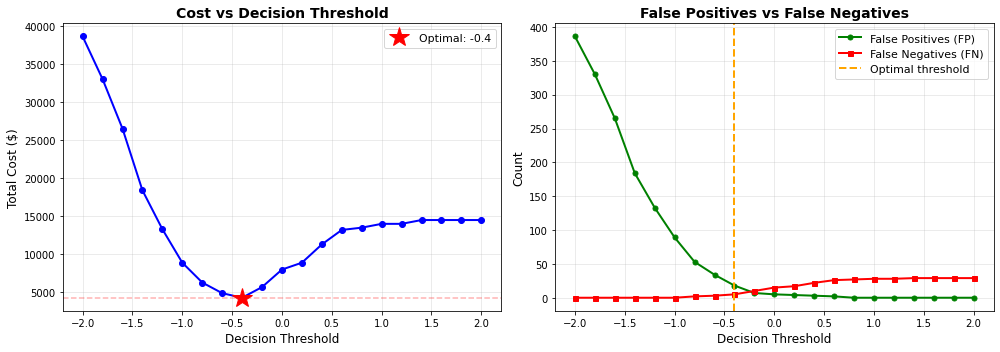


📊 Visualization Insights:
LEFT PLOT: Shows how total cost changes with threshold
  • Lower threshold → flag more as fraud → fewer FN, more FP
  • Higher threshold → flag less as fraud → more FN, fewer FP
  • Optimal threshold minimizes total cost

RIGHT PLOT: Shows the trade-off between FP and FN
  • As threshold decreases, FP increases (green line up)
  • As threshold decreases, FN decreases (red line down)
  • Optimal threshold balances these based on costs ($100 vs $500)
  • Since FN costs 5× more, we tolerate more FP to reduce FN


In [ ]:
# BONUS: Visualize the threshold optimization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get the data for plotting
clf = LinearSVC(C=1.0, max_iter=10_000, random_state=0)
X_train, X_test, y_train, y_test = train_test_split_table(fraud_data)
clf.fit(X_train, y_train)
thresholds = np.linspace(-2.0, 2.0, 21)
df_results = sweep_thresholds(y_test, thresholds, X_test, clf)

# Plot 1: Total Cost vs Threshold
axes[0].plot(df_results['threshold'], df_results['total_cost'], 'b-o', linewidth=2, markersize=6)
optimal_idx = df_results['total_cost'].idxmin()
optimal_threshold = df_results.loc[optimal_idx, 'threshold']
optimal_cost = df_results.loc[optimal_idx, 'total_cost']
axes[0].plot(optimal_threshold, optimal_cost, 'r*', markersize=20, label=f'Optimal: {optimal_threshold:.1f}')
axes[0].axhline(y=optimal_cost, color='r', linestyle='--', alpha=0.3)
axes[0].set_xlabel('Decision Threshold', fontsize=12)
axes[0].set_ylabel('Total Cost ($)', fontsize=12)
axes[0].set_title('Cost vs Decision Threshold', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)

# Plot 2: FP and FN counts
axes[1].plot(df_results['threshold'], df_results['FP'], 'g-o', linewidth=2, label='False Positives (FP)', markersize=5)
axes[1].plot(df_results['threshold'], df_results['FN'], 'r-s', linewidth=2, label='False Negatives (FN)', markersize=5)
axes[1].axvline(x=optimal_threshold, color='orange', linestyle='--', linewidth=2, label=f'Optimal threshold')
axes[1].set_xlabel('Decision Threshold', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('False Positives vs False Negatives', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Visualization Insights:")
print("=" * 70)
print("LEFT PLOT: Shows how total cost changes with threshold")
print("  • Lower threshold → flag more as fraud → fewer FN, more FP")
print("  • Higher threshold → flag less as fraud → more FN, fewer FP")
print("  • Optimal threshold minimizes total cost")
print()
print("RIGHT PLOT: Shows the trade-off between FP and FN")
print("  • As threshold decreases, FP increases (green line up)")
print("  • As threshold decreases, FN decreases (red line down)")  
print("  • Optimal threshold balances these based on costs ($100 vs $500)")
print("  • Since FN costs 5× more, we tolerate more FP to reduce FN")
print("=" * 70)